In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import yaml
import time
import torch
import pprint

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchinfo import summary
from IPython.display import YouTubeVideo
from IPython.display import clear_output
from roboflow import Roboflow

In [2]:
from super_gradients.training import models
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from super_gradients.training import training_hyperparams

In [3]:
rf = Roboflow(api_key="u5EbQMhc5BW6bhrnZWYy")
project = rf.workspace("research-projects-qodgb").project("vehicle-body-style-dataset")
dataset = project.version(2).download("yolov5")

Extracting Dataset Version Zip to Vehicle-Body-Style-Dataset-2 in yolov5pytorch:: 100%|████████████████████████████████████████████████████████| 20012/20012 [00:04<00:00, 4199.86it/s]


In [4]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'Z:/CompCarsYOLO/model/' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'yolo_car_type_identifier' #specify the experiment name

    #dataset params
    DATA_DIR = 'Z:/NAS_Model_Construction/Vehicle-Body-Style-Dataset-2/' #parent directory to where data lives

    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are

    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['MPV', 'SUV', 'sedan', 'hatchback', 'minibus', 'fastback', 'estate', 
               'pickup', 'hardtop convertible', 'sports', 'crossover', 'convertible'] #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':4,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_s' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [5]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES,
        'input_dim': [320, 320]
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES,
        'input_dim': [320, 320]
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES,
        'input_dim': [320, 320]
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Indexing dataset annotations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 987/987 [00:06<00:00, 144.46it/s]


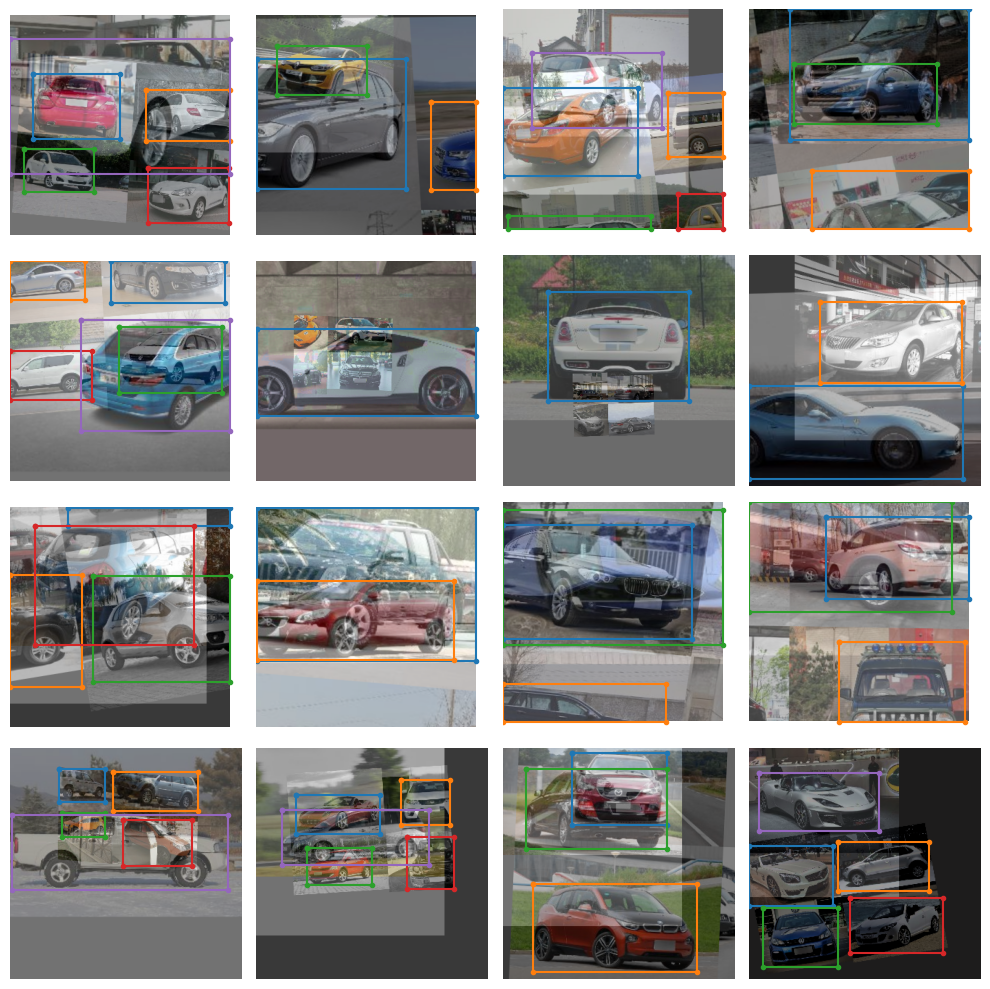

In [7]:
train_data.dataset.plot()

In [8]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

In [9]:
train_params = {
    'average_best_models': True,
    'zero_weight_decay_on_bias_and_bn': True,
    'lr_warmup_epochs': 3,
    'warmup_mode': 'LinearEpochLRWarmup',
    'initial_lr': 5e-4,
    'cosine_final_lr_ratio': 0.1,
    'optimizer': "Adam",
    'optimizer_params': {
        'weight_decay': 0.0001 },
    'ema': True,
    'ema_params': {
        'decay': 0.9 },
    'max_epochs': 100,
    'mixed_precision': True,
    # 'criterion_params': [
    #     'num_classes': config.NUM_CLASSES
    #     'reg_max': 16 ]
    
     "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),

    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls= config.NUM_CLASSES,
            normalize_targets = True,
            post_prediction_callback = PPYoloEPostPredictionCallback(
                score_threshold = 0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

Train epoch 0: 100%|██████████| 1753/1753 [04:59<00:00,  5.86it/s, PPYoloELoss/loss=2.25, PPYoloELoss/loss_cls=1.42, PPYoloELoss/loss_dfl=0.485, PPYoloELoss/loss_iou=0.345, gpu_mem=0.
Validating: 100%|██████████| 499/499 [00:36<00:00, 13.79it/s]
Train epoch 1: 100%|██████████| 1753/1753 [04:39<00:00,  6.28it/s, PPYoloELoss/loss=2.17, PPYoloELoss/loss_cls=1.35, PPYoloELoss/loss_dfl=0.481, PPYoloELoss/loss_iou=0.334, gpu_mem=0.
Validating epoch 1: 100%|██████████| 499/499 [00:34<00:00, 14.56it/s]
Train epoch 2: 100%|██████████| 1753/1753 [04:35<00:00,  6.36it/s, PPYoloELoss/loss=2.18, PPYoloELoss/loss_cls=1.35, PPYoloELoss/loss_dfl=0.492, PPYoloELoss/loss_iou=0.342, gpu_mem=0.
Validating epoch 2: 100%|██████████| 499/499 [00:33<00:00, 14.91it/s]
Train epoch 3: 100%|██████████| 1753/1753 [04:36<00:00,  6.34it/s, PPYoloELoss/loss=2.18, PPYoloELoss/loss_cls=1.35, PPYoloELoss/loss_dfl=0.495, PPYoloELoss/loss_iou=0.342, gpu_mem=0.
Validating epoch 3: 100%|██████████| 499/499 [00:40<00:00, 12.

In [ ]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

In [ ]:
# best_model.predict( "path/to/your/asset",  conf=0.25).show()